In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
from matplotlib import pyplot as plt
import seaborn as sns
import folium
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder

In [2]:
file_path = '/content/FMCG_2022_2024.csv'
data = pd.read_csv(file_path)

data.head()

,date,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
0,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,1,141,128,9
1,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,3,0,129,0
2,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,5,118,161,8
3,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,2,81,114,7
4,2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,4,148,204,12


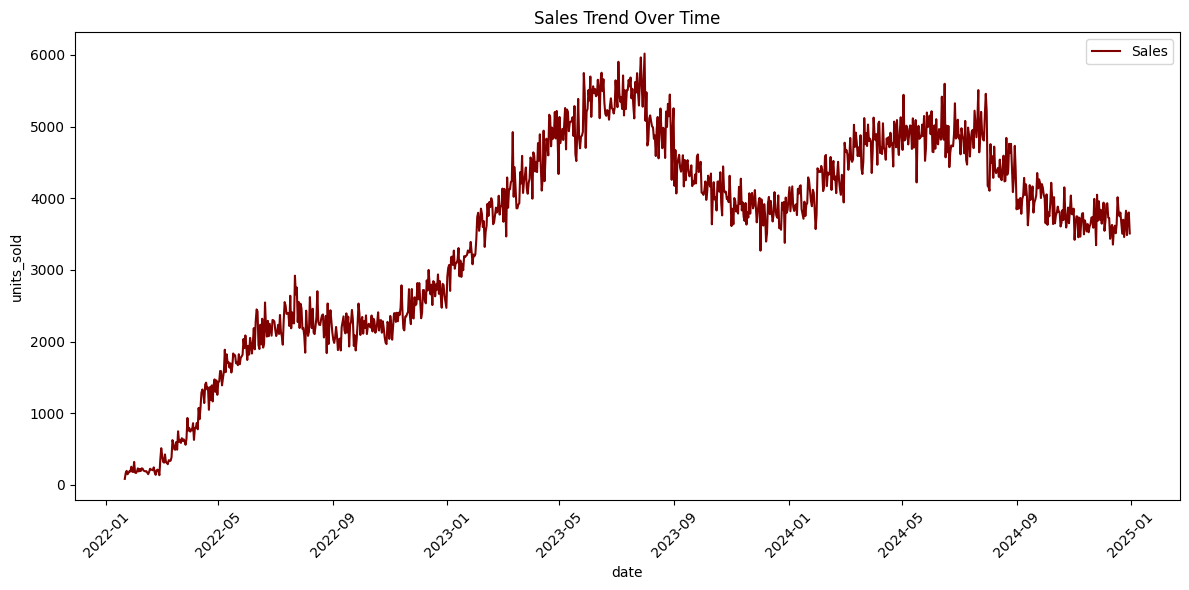

In [16]:
data['date'] = pd.to_datetime(data['date'])

sales_by_date = data.groupby('date')['units_sold'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(sales_by_date['date'], sales_by_date['units_sold'], label='Sales', color='maroon')
plt.title('Sales Trend Over Time')
plt.xlabel('date')
plt.ylabel('units_sold')
plt.grid(False)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

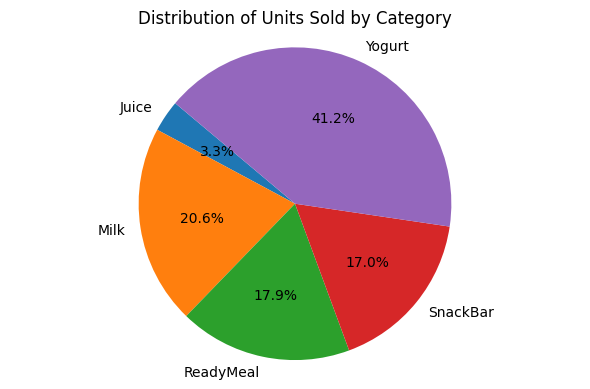

In [29]:
sales_by_category = data.groupby('category')['units_sold'].sum().reset_index()

plt.figure(figsize=(6, 4))
plt.pie(sales_by_category['units_sold'], labels=sales_by_category['category'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Units Sold by Category')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [7]:
def create_lagged_features(data, lag=1):
    lagged_data = data.copy()
    for i in range(1, lag+1):
        lagged_data[f'lag_{i}'] = lagged_data['units_sold'].shift(i)
    return lagged_data

lag = 5
sales_with_lags = create_lagged_features(data[['date', 'units_sold']], lag)

sales_with_lags = sales_with_lags.dropna()

In [8]:
X = sales_with_lags.drop(columns=['date', 'units_sold'])
y = sales_with_lags['units_sold']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [9]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [12]:
predictions_xgb = model_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))

print(f"RMSE: {rmse_xgb:.2f}")

RMSE: 9.96


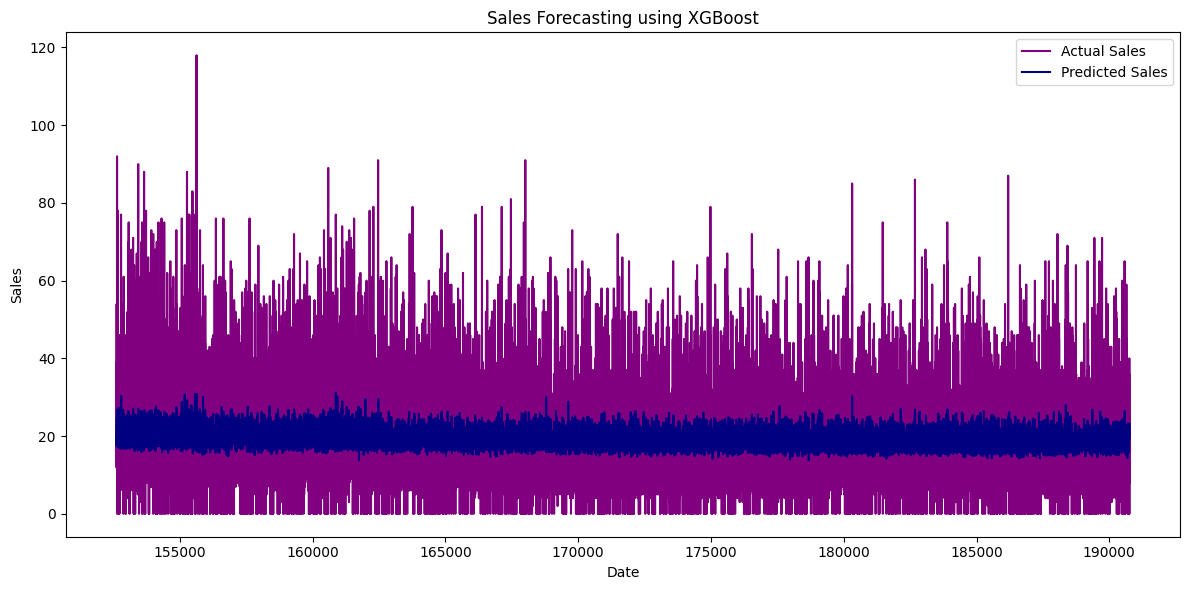

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Sales', color='purple')
plt.plot(y_test.index, predictions_xgb, label='Predicted Sales', color='navy')
plt.title('Sales Forecasting using XGBoost')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()